# Get data for processing

We use **Kaggle** flatform to run this notebook.

Import **libri-speech-noise-dataset"** to **/kaggle/input/** before running code.

In [1]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.6 MB/s eta 0:00:00


In [2]:
import py7zr

def extract_7z(file_path, output_path):
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(output_path)

extract_7z("/kaggle/input/libri-speech-noise-dataset/test.7z", '/kaggle/working/')
extract_7z("/kaggle/input/libri-speech-noise-dataset/y_test.7z", '/kaggle/working/')

In [3]:
!git clone https://github.com/bdbao/AI-Noise-Reduction-in-Speech
%cd /kaggle/working/AI-Noise-Reduction-in-Speech

Cloning into 'AI-Noise-Reduction-in-Speech'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 378 (delta 15), reused 105 (delta 9), pack-reused 263
Receiving objects: 100% (378/378), 154.78 MiB | 25.27 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (321/321), done.
/kaggle/working/AI-Noise-Reduction-in-Speech


In [4]:
import librosa
import numpy as np
import os


def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array


def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)

        if (total_duration >= min_duration):
            list_sound_array.append(audio_to_audio_frame_stack(
                y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)


def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice


def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase


def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

# Predict speech denoising + Visualization

## Define functions

In [5]:
!mkdir '/kaggle/working/output_denoised'

In [6]:
from matplotlib import pyplot as plt

def make_4plots_spec_voice_noise(stftvoicenoise_mag_db,stftnoise_mag_db,stftvoice_mag_db,stftvoicenoise_pha_db,sample_rate, hop_length_fft):
    """This function plots the spectrograms of noisy voice, noise and voice as a single plot """
    plt.figure(figsize=(8, 16))
    plt.subplot(4, 1, 1)
    plt.title('Spectrogram magnitude voice + noise')
    librosa.display.specshow(stftvoicenoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(4, 1, 2)
    plt.title('Spectrogram predicted voice')
    librosa.display.specshow(stftnoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(4, 1, 3)
    plt.title('Spectrogram denoise voice')
    librosa.display.specshow(stftvoice_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(4, 1, 4)
    plt.title('Spectrogram phase voice + noise')
    librosa.display.specshow(stftvoicenoise_pha_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.tight_layout()

    return

def make_3plots_timeseries_voice_noise(clipvoicenoise, clipnoise, clipvoice, sample_rate):
    """This function plots the time series of audio of noisy voice, noise and voice as a single plot """
    #y_ax_min = min(clipvoicenoise) - 0.15
    #y_ax_max = max(clipvoicenoise) + 0.15

    plt.figure(figsize=(12, 15))
    
    plt.subplot(3, 1, 1)
    plt.title('Audio voice + noise')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipvoicenoise, sr=sample_rate)
    
    plt.subplot(3, 1, 2)
    plt.title('Audio predicted voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipnoise, sr=sample_rate)
    
    plt.subplot(3, 1, 3)
    plt.title('Audio true voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipvoice, sr=sample_rate)

    return

In [7]:
import librosa
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import soundfile as sf


def prediction(audio_dir_prediction, audio_input_prediction, audio_output_prediction):
    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    # Global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    # Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    # Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    # Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    # Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    # Reconstruct audio from denoised spectrogram and phase
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    nb_samples = audio_denoise_recons.shape[0]
    
    
    make_4plots_spec_voice_noise(m_amp_db_audio[0,:,:], inv_sca_X_pred[:,:,:,0][0,:,:], X_denoise[0,:,:], m_pha_audio[0,:,:],sample_rate, hop_length_fft)
    
    
    # Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    sf.write(audio_output_prediction, denoise_long[0, :], sample_rate)

print("Define function. Done!")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Define function. Done!


## Load model

In [8]:
weights_path = './weights'
name_model = 'model_unet'
sample_rate = 8000
min_duration = 1.0      # Minimum duration of audio files to consider
frame_length = 8064     # Our training data will be frame of slightly above 1 second
hop_length_frame = 8064 # Hop length for clean voice files separation (no overlap)
n_fft = 255             # Choosing n_fft and hop_length_fft to have squared spectrograms
hop_length_fft = 63

# Load model
json_file = open(weights_path + '/' + name_model + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model.load_weights(weights_path + '/' + name_model +'.h5')

print("Load model. Done!")

Load model. Done!


## Predict an arbitrary uploaded audio

In [9]:
audio_dir_prediction = '/kaggle/working/test'
audio_input_prediction = ['730-358-0037.wav']
audio_output_prediction = '/kaggle/working/output_denoised/output.wav'

### Spectrogram plot

1/1 [==============================] - 1s 870ms/step


/tmp/ipykernel_32/2631687841.py:20: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stftvoicenoise_pha_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)


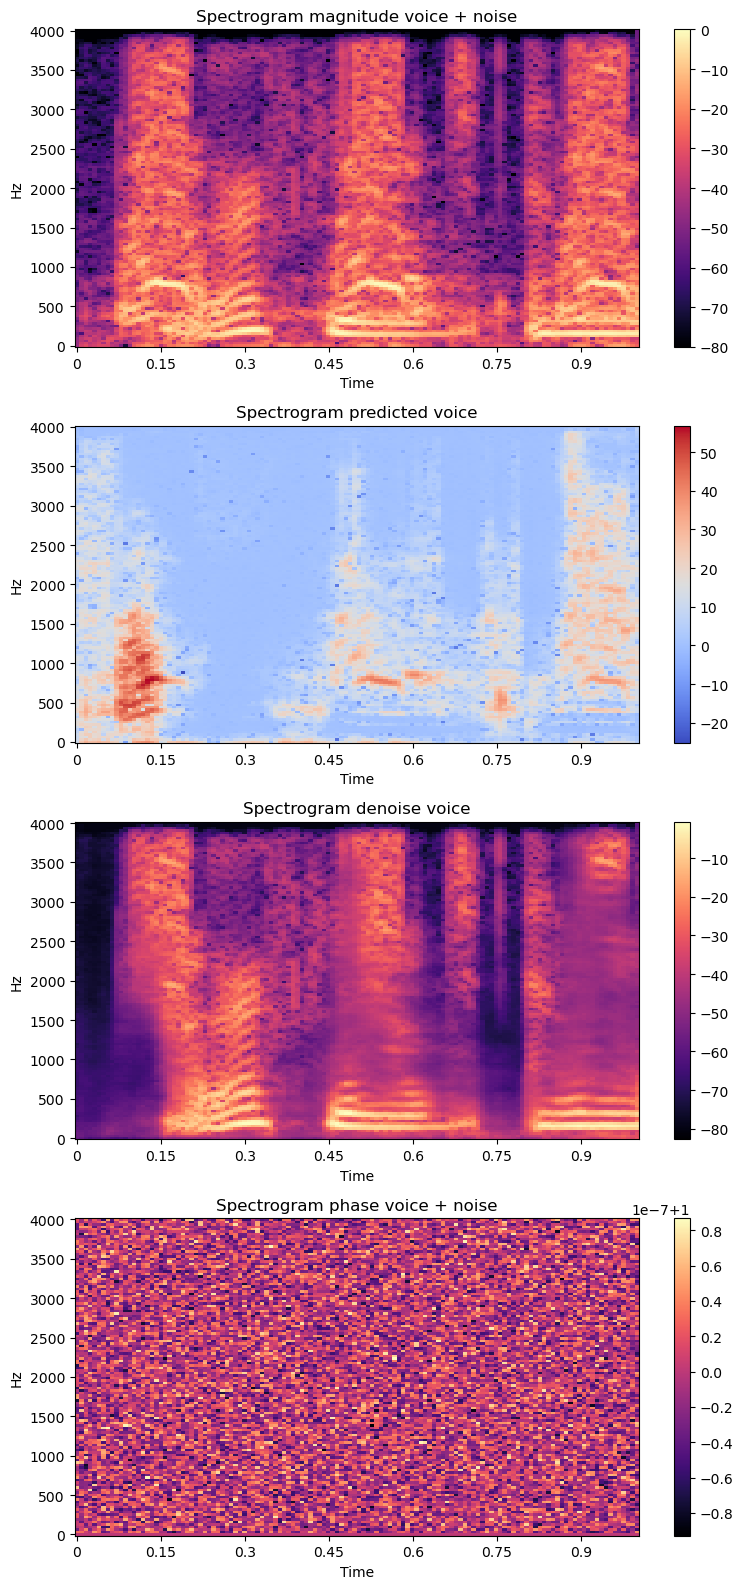

In [10]:
prediction(audio_dir_prediction, audio_input_prediction, audio_output_prediction)

### Play audio

In [11]:
from IPython.display import display, Audio

print("Audio with noise:")
display(Audio(os.path.join(audio_dir_prediction, audio_input_prediction[0])))
print("Audio after denoising:")
display(Audio(audio_output_prediction))
print("Truth clean audio:")
display(Audio(os.path.join('/kaggle/working/y_test', audio_input_prediction[0])))

Audio with noise:


Audio after denoising:


Truth clean audio:


### Compute SDR, SNR, PESQ score

In [12]:
!python -m pip install --upgrade pip setuptools wheel # for error: setup.py for metadata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.1/805.1 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.40.0
    Uninstalling wheel-0.40.0:
      Successfully uninstalled wheel-0.40.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is inc

In [13]:
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=108980 sha256=d5889baefbc8009f01d869fcb7f4999610812f17d7c6f2f6f2b2c7657e5a8031
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [14]:
from pydub import AudioSegment
import numpy as np
from pesq import pesq

def compute_sdr(noise_audio, clean_audio, enhanced_audio):
    noise_audio = np.array(noise_audio.get_array_of_samples())
    clean_audio = np.array(clean_audio.get_array_of_samples())
    enhanced_audio = np.array(enhanced_audio.get_array_of_samples())
    
    error_signal = noise_audio - clean_audio
    sdr = 10 * np.log10(np.sum(clean_audio ** 2) / np.sum(error_signal ** 2))
    return sdr

def compute_snr(noise_audio, clean_audio, enhanced_audio):
    noise_audio = np.array(noise_audio.get_array_of_samples())
    clean_audio = np.array(clean_audio.get_array_of_samples())
    enhanced_audio = np.array(enhanced_audio.get_array_of_samples())
    # Make the lengths match
    clean_audio = clean_audio[:len(enhanced_audio)]
    
    noise_signal = clean_audio - enhanced_audio
    snr = 10 * np.log10(np.sum(clean_audio ** 2) / np.sum(noise_signal ** 2))
    return snr

# Compute PESQ (Perceptual Evaluation of Speech Quality) score using the pesq library
def compute_pesq(clean_audio, enhanced_audio):
    pesq_score = pesq(ref=np.array(clean_audio.get_array_of_samples()), deg=np.array(enhanced_audio.get_array_of_samples()), fs=clean_audio.frame_rate)
    return pesq_score

In [15]:
# Load audio files
noise_audio = AudioSegment.from_file(audio_dir_prediction + '/' + audio_input_prediction[0])
clean_audio = AudioSegment.from_file('/kaggle/working/y_test/' + audio_input_prediction[0])
enhanced_audio = AudioSegment.from_file(audio_output_prediction)

# Compute SDR and SNR
sdr = compute_sdr(noise_audio, clean_audio, enhanced_audio)
snr = compute_snr(noise_audio, clean_audio, enhanced_audio)
pesq_score = compute_pesq(clean_audio, enhanced_audio)

print("SDR:", sdr, "dB")
print("SNR:", snr, "dB")
print("PESQ score:", pesq_score)

SDR: 1.460144781604043 dB
SNR: 4.861477297826674 dB
PESQ score: 1.2340450286865234


### Waveform plot

In [16]:
noisy_voice, _ = librosa.load(os.path.join(audio_dir_prediction, audio_input_prediction[0]), sr=sample_rate)
voice_pred, _ = librosa.load(audio_output_prediction, sr=sample_rate)
voice_truth, _ = librosa.load(os.path.join('/kaggle/working/y_test', audio_input_prediction[0]), sr=sample_rate)

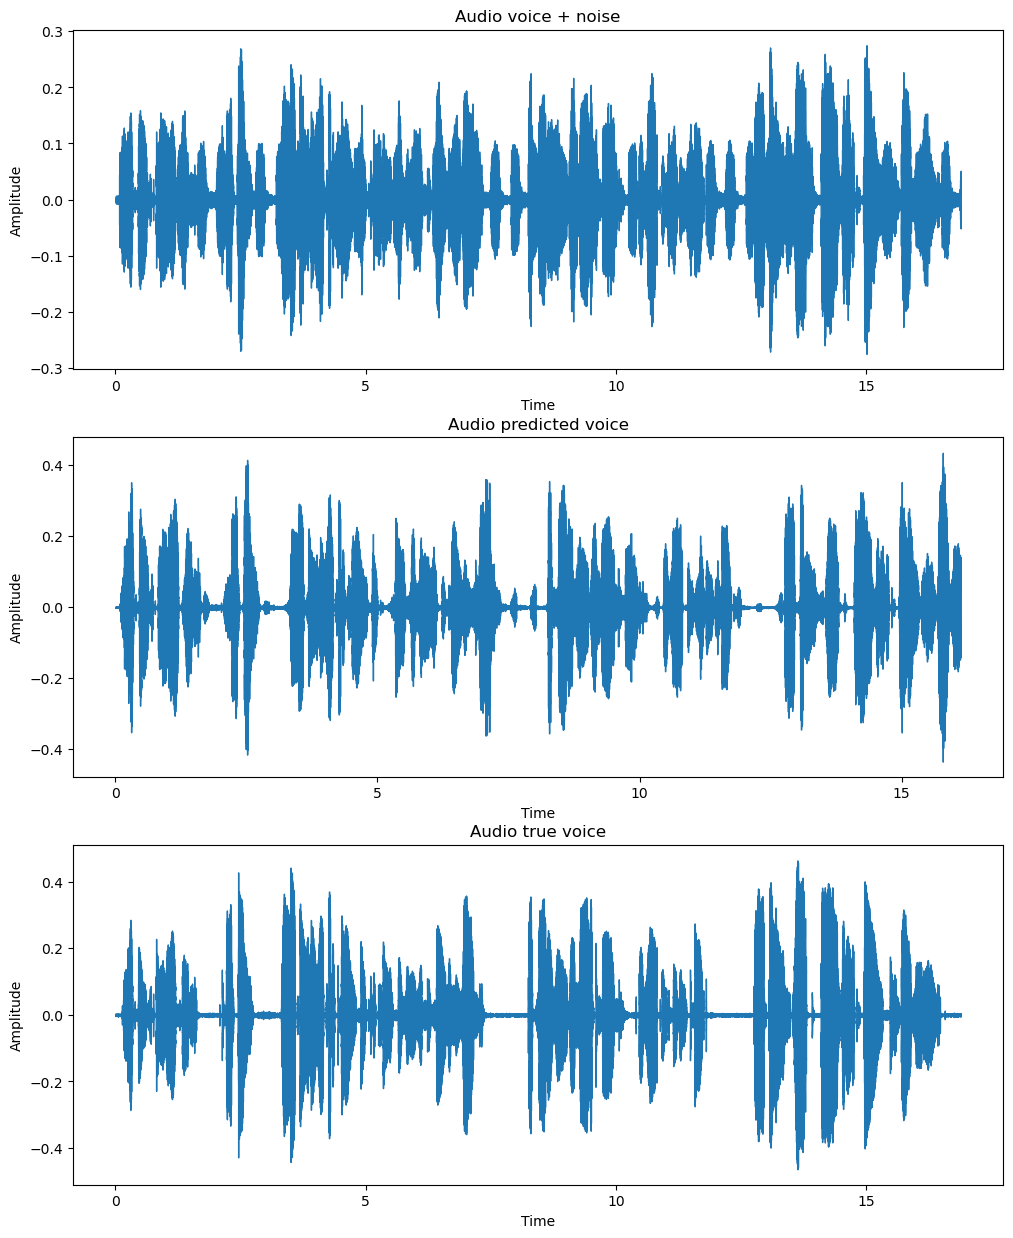

In [17]:
make_3plots_timeseries_voice_noise(noisy_voice, voice_pred, voice_truth, sample_rate)